In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from fastai_lib import *

## initial data setup

In [6]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

Short intro: if you can get a small batch going fairly going well, you are off to a good start for super convergence

In [7]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [9]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [10]:
run.fit(3, learn)

train: [0.69311296875, tensor(0.7930)]
valid: [0.3344400146484375, tensor(0.9039)]
train: [0.297352734375, tensor(0.9134)]
valid: [0.2290689697265625, tensor(0.9360)]
train: [0.23737439453125, tensor(0.9318)]
valid: [0.19877386474609374, tensor(0.9448)]


In [11]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7548671875, tensor(0.7975)]
valid: [0.355202783203125, tensor(0.9003)]
train: [0.3477811328125, tensor(0.8997)]
valid: [0.291547705078125, tensor(0.9151)]
train: [0.294677890625, tensor(0.9154)]
valid: [0.2694351806640625, tensor(0.9209)]


In [12]:
#export
def get_model_func(lr=0.5): 
    return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

In [13]:
class Recorder(Callback):
    """
    This is to assist in visualizing what is happening
    There's a lot of learning rates (could be different for)
    each groups
    """
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self):
        plt.plot(self.lrs)

    def plot_loss(self):
        plt.plot(self.losses)


class ParamScheduler(Callback):
    """
    Schedules any parameter, learning rate / dropout / weight decay etc.
    """
    _order=1
    def __init__(self, pname, sched_func): 
        self.pname, self.sched_func = pname, sched_func

    def set_param(self):
        
        # param_groups (layer groups)
        # loop through different groups of layers
        for pg in self.opt.param_groups:

            # float of how far we are through training
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: 
            self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

In [15]:
def sched_lin(start, end):
    """
    THis is a function that will return a function
    """
    def _inner(start, end, pos): 
        return start + pos*(end-start)
    
    # returns a function that only takes position
    return partial(_inner, start, end)

## decorators

This is an example of a decorator, so it can be used for any number of times. A decorator is a function that returns a function. It will pass the following function into the `@` related function. When defining custom decorators, make sure to return another function

In [18]:
#export
def annealer(f):
    def _inner(start, end): 
        return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): 
    return start + pos*(end-start)

In [20]:
# shift-tab works too, in Jupyter!
# sched_lin()

In [21]:
f = sched_lin(1,2)
f(0.3)

1.3

In [22]:
#export
@annealer
def sched_cos(start, end, pos): 
    """
    returns a cosine
    """
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_no(start, end, pos):
    """
    Always returns start
    """
    return start

@annealer
def sched_exp(start, end, pos): 
    return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

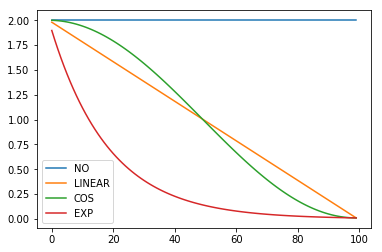

In [23]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In general what you want is startup / cooldown / etc.

In [24]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [25]:
sched = combine_scheds(
    [0.3, 0.7],
    [sched_cos(0.3, 0.6), 
     sched_cos(0.6, 0.2)]
) 

### example of cosine schedule

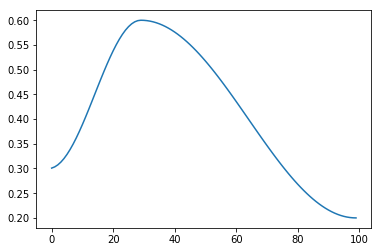

In [26]:
plt.plot(a, [sched(o) for o in p])

In [27]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [28]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [29]:
run.fit(3, learn)

train: [0.7897296875, tensor(0.7816)]
valid: [0.3424356201171875, tensor(0.8957)]
train: [0.3020026953125, tensor(0.9124)]
valid: [0.2414274169921875, tensor(0.9322)]
train: [0.24016177734375, tensor(0.9316)]
valid: [0.2119968017578125, tensor(0.9418)]


... then check with our recorder if the learning rate followed the right schedule.

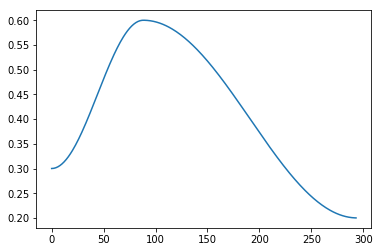

In [31]:
run.recorder.plot_lr()

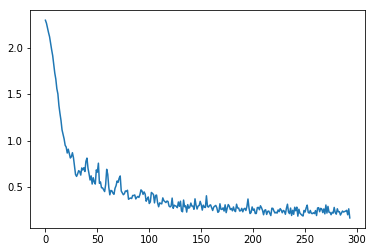

In [32]:
run.recorder.plot_loss()